# Deep learning volume segmentation

Authors: Alessia Saccardo (s212246@dtu.dk) & Felipe Delestro (fima@dtu.dk)

This notebook aims to demonstrate the feasibility of implementing a comprehensive deep learning segmentation pipeline solely leveraging the capabilities offered by the `qim3d` library. Specifically, it will highlight the utilization of the annotation tool and walk through the process of creating and training a Unet model.

### Imports

In [1]:
import qim3d
import numpy as np 
import os 

### Load data
The `qim3d` library contains a set of example volumes which can be easily loaded using `qim3d.examples.{volume_name}`

In [2]:
vol = qim3d.examples.bone_128x128x128

To easily have an insight of how the volume looks like we can interact with it using the `slicer` function from `qim3d`

In [3]:
qim3d.viz.slicer(vol)

interactive(children=(IntSlider(value=64, description='Slice', max=127), Output()), layout=Layout(align_items=…

# Generate dataset for training

In order to train the classification model, we need to create a dataset from the volume.

This means that we'll need a few slices to be used for `training` and at least one for the `test`

The dataset for training the model is managed by `qim3d.utils.prepare_datasets` and it expects files to follow this structure:

<pre>
dataset
├── test
│   ├── images
│   │   └── FileA.png
│   └── labels
│       └── FileA.png
└── train
    ├── images
    │   ├── FileB.png
    │   └── FileC.png
    └── labels
        ├── FileB.png
        └── FileC.png


</pre>


In [4]:
# Number of slices that will be used
num_training = 4
num_test = 1

In the following cell, we get the slice indices, making sure that we're not using the same indices for training and test.

In [5]:
# Seed for random number generator
seed = 0

# Create a set with all the indices
all_idxs = set(range(vol.shape[0]))

# Get indices for training data
training_idxs = list(np.random.default_rng(seed).choice(list(all_idxs), size=num_training))
print(f"Slices for training data...: {training_idxs}")

# Get indices for test data
test_idxs = list(np.random.default_rng(seed).choice(list(all_idxs - set(training_idxs)), size=num_test, replace=False))
print(f"Slices for test data.......: {test_idxs}")

Slices for training data...: [108, 81, 65, 34]
Slices for test data.......: [109]


## Create folder structure
Here we create the necessary directories

In [6]:
# Base path for the training data
base_path = os.path.expanduser("~/dataset")

# Create directories
print("Creating directories:")
for folder_split in ["train", "test"]:
    for folder_type in ["images", "labels"]:
        path = os.path.join(base_path, folder_split, folder_type)
        os.makedirs(path, exist_ok=True)
        print(path)

# Here we have the option to remove any previous files
clean_files = True
if clean_files:
    for root, dirs, files in os.walk(base_path):
        for file in files:
            file_path = os.path.join(root, file)
            os.remove(file_path)

Creating directories:
C:\Users\s193396/dataset\train\images
C:\Users\s193396/dataset\train\labels
C:\Users\s193396/dataset\test\images
C:\Users\s193396/dataset\test\labels


# Annotate data

The following cell will generate an annotation tool for each slice that was requested. 

You should use the tool to drawn a mask over the structures you're willing to detect.

In [7]:
annotation_tools = {}
for idx in training_idxs + test_idxs:
    if idx in training_idxs:
        subset = "training"
    elif idx in test_idxs:
        subset = "test"
    annotation_tools[idx] = qim3d.gui.annotation_tool.Interface()
    annotation_tools[idx].name_suffix = f"_{idx}"  
    print(f"Annotation for slice {idx} ({subset})")
    annotation_tools[idx].launch(vol[idx])

Annotation for slice 108 (training)


Annotation for slice 81 (training)


Annotation for slice 65 (training)


c:\Users\s193396\AppData\Local\miniconda3\envs\qim3d\lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Annotation for slice 34 (training)

Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB


c:\Users\s193396\AppData\Local\miniconda3\envs\qim3d\lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Annotation for slice 109 (test)


c:\Users\s193396\AppData\Local\miniconda3\envs\qim3d\lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


c:\Users\s193396\AppData\Local\miniconda3\envs\qim3d\lib\site-packages\gradio\analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


### Getting masks from the annotation tool
The masks are stored in the annotation tool. Here we extract the masks and save them to disk, following the standard needed for the DL model.

In [9]:
print("Saving images and masks to disk")
for idx in training_idxs + test_idxs:
    
    if idx in training_idxs:
        folder_split = "train"

    elif idx in test_idxs:
        folder_split = "test"

    print (f"- slice {idx} ({folder_split})")
    mask_dict = annotation_tools[idx].get_result()
    mask = list(mask_dict.values())[0]

    # Save image
    qim3d.io.save(os.path.join(base_path,folder_split,"images",f"{idx}.png"), vol[idx], replace=True)
    # Save label
    qim3d.io.save(os.path.join(base_path,folder_split,"labels",f"{idx}.png"), mask, replace=True)


Loaded shape: (128, 128)
INFO:qim3d:Loaded shape: (128, 128)
Volume using 16.0 KB of memory

INFO:qim3d:Volume using 16.0 KB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
INFO:qim3d:System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
Loaded shape: (128, 128)
INFO:qim3d:Loaded shape: (128, 128)
Volume using 16.0 KB of memory

INFO:qim3d:Volume using 16.0 KB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
INFO:qim3d:System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
Loaded shape: (128, 128)
INFO:qim3d:Loaded shape: (128, 128)
Volume using 16.0 KB of memory

INFO:qim3d:Volume using 16.0 KB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
INFO:qim3d:System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
Loaded shape: (128, 128)


Saving images and masks to disk
- slice 108 (train)
- slice 81 (train)
- slice 65 (train)
- slice 34 (train)


INFO:qim3d:Loaded shape: (128, 128)
Volume using 16.0 KB of memory

INFO:qim3d:Volume using 16.0 KB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
INFO:qim3d:System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
Loaded shape: (128, 128)
INFO:qim3d:Loaded shape: (128, 128)
Volume using 16.0 KB of memory

INFO:qim3d:Volume using 16.0 KB of memory

System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)
INFO:qim3d:System memory:
 • Total.: 31.6 GB
 • Used..: 15.8 GB (50.0%)
 • Free..: 15.8 GB (50.0%)


- slice 109 (test)


# Build Unet

Building and training the Unet model is straightforward using `qim3d`. 

We first need to instantiate the model by defining its size, which can be either *small*, *medium* or *large*. 

In [10]:
# defining model
model = qim3d.ml.models.UNet(size = 'small', dropout = 0.25)

Then we need to decide which type of augumentation to apply to the data. 

The `qim3d.ml.Augmentation` allows to specify how the images should be reshaped to the appropriate size and the level of transformation to apply respectively to train, test and validation sets. 

The resize must be choosen between [*crop*, *reshape*, *padding*] and the level of transformation must be chosse between [*None*, *light*, *moderate*, *heavy*]. The user can also specify the mean and standard deviation values for normalizing pixel intensities.

In [11]:
# defining augmentation
aug =  qim3d.ml.Augmentation(resize = 'crop', transform_train = 'light')

Then the datasets and dataloaders are instantiated 

In [12]:
# datasets and dataloaders
train_set, val_set, test_set = qim3d.ml.prepare_datasets(path = base_path,
                                                            val_fraction = 0.5,
                                                            model = model,
                                                            augmentation = aug)


train_loader, val_loader, test_loader = qim3d.ml.prepare_dataloaders(train_set, 
                                                                        val_set,
                                                                        test_set,
                                                                        batch_size = 1)

The hyperparameters are defined using the function `qim3d.ml.Hyperparameters` and the model can be easily trained by running the function `qim3d.ml.train_model` which returns also a plot of the losses at the end of the training if the option is selected by the user 

# Train model

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   0, train loss: 1.9671, val loss: 1.5506
Epoch   5, train loss: 0.9591, val loss: 0.8574


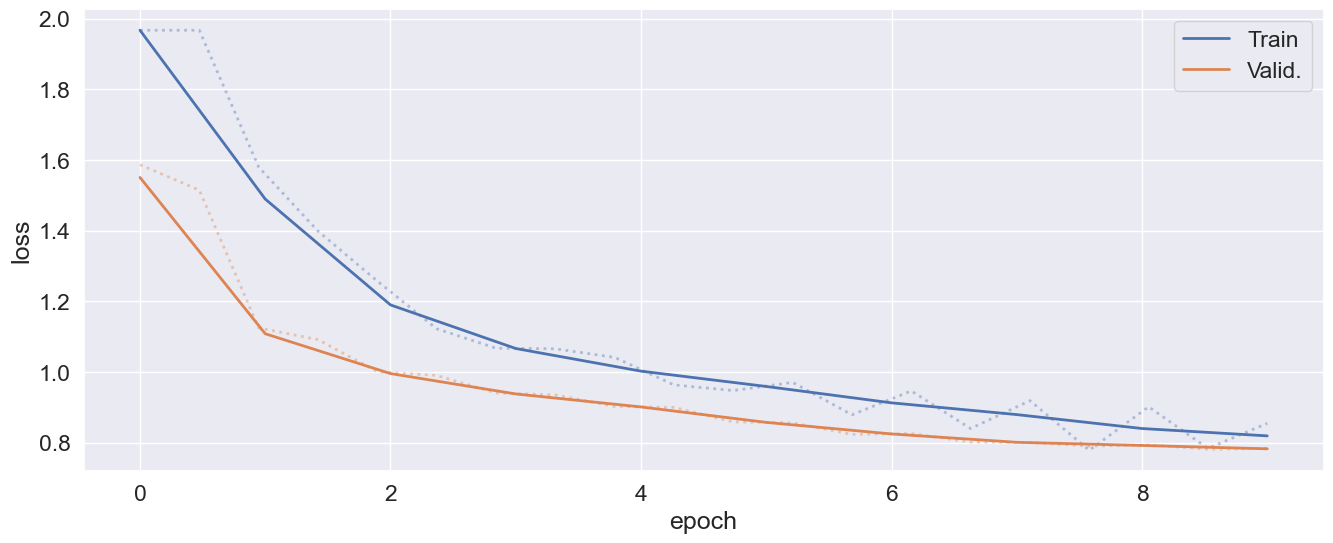

In [13]:
# model hyperparameters
hyperparameters = qim3d.ml.Hyperparameters(model, n_epochs=10, 
                                               learning_rate = 5e-3, loss_function='DiceCE',
                                               weight_decay=1e-3)

# training model
qim3d.ml.train_model(model, hyperparameters, train_loader, val_loader, plot=True)

# Check results

To compute the inference step it is just needed to run `qim3d.ml.inference`.

The results can be visualize with the function `qim3d.viz.grid_pred` that shows the predicted segmentation along with a comparison between the ground truth.

Not enough images in the dataset. Changing num_images=7 to num_images=1


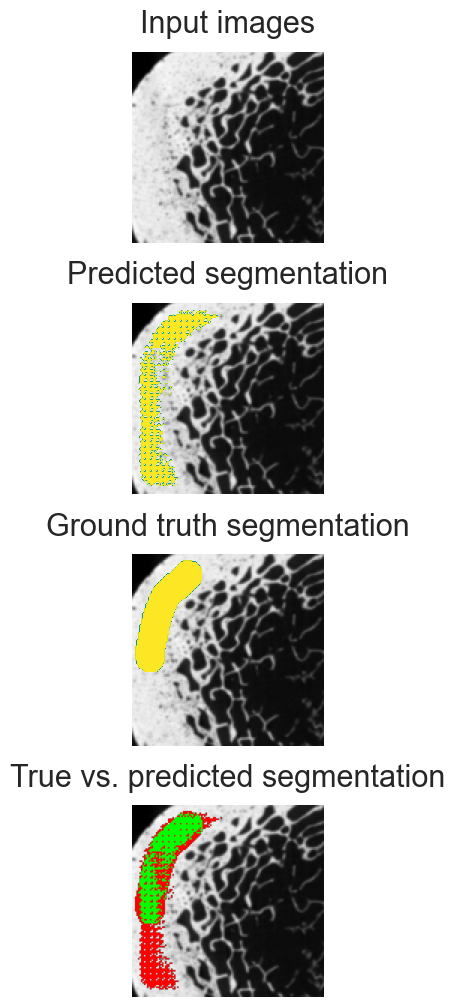

In [14]:
in_targ_preds_test = qim3d.ml.inference(test_set, model)
qim3d.viz.grid_pred(in_targ_preds_test,alpha=1)

# Compute inference on entire volume

Given that the input is a volume, the goal is to perform inference on the entire volume rather than individual slices.

By using the function `qim3d.ml.volume_inference` it is possible to obtain the segmentation volume output

In [15]:
inference_vol = qim3d.ml.volume_inference(vol, model)
qim3d.viz.slicer(inference_vol)

interactive(children=(IntSlider(value=64, description='Slice', max=127), Output()), layout=Layout(align_items=…

We can also visualize the created mask together with the original volume

In [17]:
vol_masked = qim3d.viz.vol_masked(vol, inference_vol, viz_delta=128)
qim3d.viz.slicer(vol_masked, color_map="PiYG")

interactive(children=(IntSlider(value=64, description='Slice', max=127), Output()), layout=Layout(align_items=…